# Лабораторная работа 12-14.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, ElasticNet
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.datasets import fetch_openml, fetch_california_housing,load_diabetes
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, precision_score, recall_score, accuracy_score, multilabel_confusion_matrix, roc_curve, auc

from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from scipy.stats import zscore

## Задача 1. Классификация изображений рукописных цифр.
+ Набор данных: MNIST.
+ Предварительная обработка: масштабирование пикселей, разделение данных на обучение и тестирование.
+ Модели: логистическая регрессия, SVM, случайный лес, градиентный бустинг, нейронные сети.
+ Сравнение модели: точность, матрица ошибок, ROC-кривые.
+ Изучение и подбор гиперпараметров: GridSearchCV или RandomizedSearchCV.
+ Визуализация: отображение изображений, важности признаков или активаций нейронной сети.


In [3]:
ds_mnist = fetch_openml('mnist_784', version=1)

X, y = ds_mnist.data, ds_mnist.target

In [4]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X, y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
models = [LogisticRegression(), SVC(), RandomForestClassifier(), GradientBoostingClassifier(), MLPClassifier()]

for model in models:
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(model)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred, average='weighted')}')
    print(f'Recall: {recall_score(y_test, y_pred, average='weighted')}')

    print(f'Матрица ошибок: {multilabel_confusion_matrix(y_test, y_pred)}')

    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        print('Feature Importance:')
        for i, importance in enumerate(feature_importance):
            print(f'Feature {i+1}: {importance}')    


LogisticRegression()
Accuracy: 0.9178571428571428
Precision: 0.9176311889392749
Recall: 0.9178571428571428
Матрица ошибок: [[[12606    51]
  [   54  1289]]

 [[12320    80]
  [   43  1557]]

 [[12491   129]
  [  151  1229]]

 [[12419   148]
  [  135  1298]]

 [[12596   109]
  [  101  1194]]

 [[12593   134]
  [  186  1087]]

 [[12524    80]
  [   64  1332]]

 [[12394   103]
  [   95  1408]]

 [[12472   171]
  [  171  1186]]

 [[12435   145]
  [  150  1270]]]
SVC()
Accuracy: 0.9764285714285714
Precision: 0.9764205434434183
Recall: 0.9764285714285714
Матрица ошибок: [[[12644    13]
  [   14  1329]]

 [[12372    28]
  [   15  1585]]

 [[12576    44]
  [   32  1348]]

 [[12526    41]
  [   47  1386]]

 [[12668    37]
  [   26  1269]]

 [[12696    31]
  [   37  1236]]

 [[12579    25]
  [   12  1384]]

 [[12457    40]
  [   38  1465]]

 [[12607    36]
  [   54  1303]]

 [[12545    35]
  [   55  1365]]]
RandomForestClassifier()
Accuracy: 0.9684285714285714
Precision: 0.9684731199519182
Recal

In [7]:
model = LogisticRegression()
model.fit(X_train, y_train)

parameters = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]
grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv = 5, verbose=0)


grid_search.fit(X_train, y_train)   

print(model)
print('Лучшие параметры GridSearchCV: ', grid_search.best_params_)
print('Лучший результат для GridSearchCV: ', grid_search.best_score_)

LogisticRegression()
Лучшие параметры GridSearchCV:  {'C': 10}
Лучший результат для GridSearchCV:  0.91875


In [ ]:
model = SVC()
model.fit(X_train, y_train)

parameters = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv = 5, verbose=0)

grid_search.fit(X_train, y_train)   

print(model)
print('Лучшие параметры GridSearchCV: ', grid_search.best_params_)
print('Лучший результат для GridSearchCV: ', grid_search.best_score_)

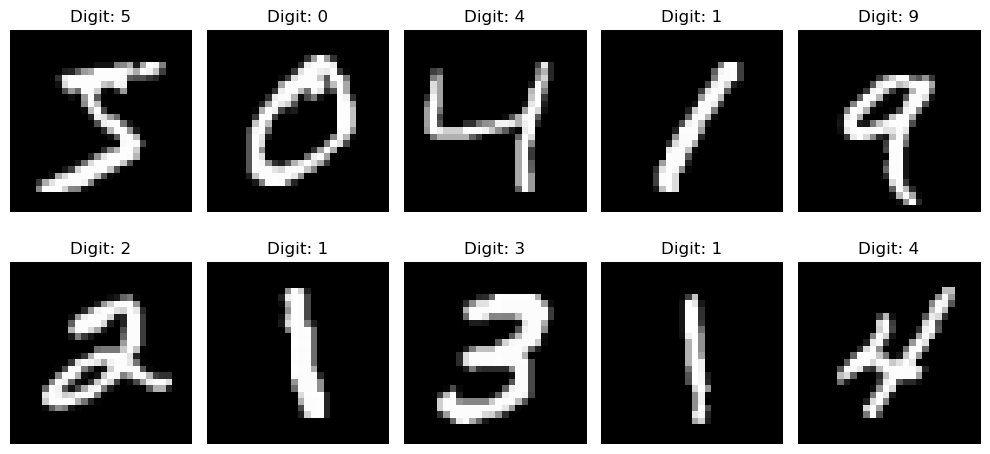

In [ ]:
images = X.values.reshape(-1, 28, 28)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Digit: {y[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Задача 2. Определение мошенничества с кредитными картами.

+ Набор данных: Credit Card Fraud Detection dataset на Kaggle.
+ Предварительная обработка: масштабирование, обработка несбалансированных данных.
+ Модели: логистическая регрессия, SVM, случайный лес, градиентный бустинг, нейронные сети.
+ Сравнение моделей: точность, полнота, ROC-кривые.
+ Изучение и подбор гиперпараметров: GridSearchCV или RandomizedSearchCV.
+ Визуализация: важности признаков, ROC-кривые.


In [ ]:
df_credit = pd.read_csv(r'Datasets\creditcard.csv')

df_credit.head(7)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0


In [ ]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
df_credit.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
df_credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
df_credit[df_credit.drop(columns=['Class']).columns] = df_credit[np.abs(zscore(df_credit) < 3).all(axis=1)][df_credit.drop(columns=['Class']).columns]

df_credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,259585.000000,259585.000000,259585.000000,259585.000000,259585.000000,259585.000000,259585.000000,259585.000000,259585.000000,259585.000000,...,259585.000000,259585.000000,259585.000000,259585.000000,259585.000000,259585.000000,259585.000000,259585.000000,259585.000000,284807.000000
mean,94498.907934,0.238825,0.032523,0.099580,-0.067048,0.005055,-0.070816,0.015809,0.052675,-0.026181,...,-0.027175,0.006990,-0.005533,-0.008393,-0.000645,-0.009663,-0.004520,-0.000580,65.578390,0.001727
std,47463.171678,1.475504,1.041336,1.302046,1.293420,1.041579,1.114350,0.811661,0.680994,0.987294,...,0.363138,0.683308,0.311327,0.594322,0.484672,0.465024,0.267714,0.172899,112.605894,0.041527
min,0.000000,-18.589909,-21.135261,-9.697346,-5.683171,-8.171011,-4.687900,-11.031780,-15.958365,-3.871558,...,-7.110652,-2.946844,-7.996811,-2.836627,-2.996548,-1.855355,-6.978859,-4.512632,0.000000,0.000000
25%,54010.000000,-0.804527,-0.567399,-0.783349,-0.851041,-0.666912,-0.769071,-0.523800,-0.191823,-0.624706,...,-0.225007,-0.535819,-0.154822,-0.356391,-0.309126,-0.327188,-0.067470,-0.051143,5.490000,0.000000
50%,83645.000000,0.184854,0.055362,0.232986,-0.049207,-0.062886,-0.300911,0.043872,0.024751,-0.052808,...,-0.033304,0.008631,-0.012284,0.037114,0.016475,-0.057676,0.000002,0.010164,21.000000,0.000000
75%,139180.000000,1.380660,0.750290,1.055029,0.680550,0.567173,0.311293,0.550153,0.309296,0.568164,...,0.171245,0.521706,0.136595,0.425997,0.343194,0.222774,0.080799,0.068515,71.840000,0.000000
max,172792.000000,2.454930,4.950561,4.101716,4.247175,4.139950,3.996601,3.710353,3.581437,3.295237,...,2.201914,2.175444,1.870667,1.425953,1.563819,1.446274,1.210855,0.989061,838.360000,1.000000


In [ ]:
X, y = df_credit.drop(columns=['Time', 'Amount', 'Class']), df_credit['Class']

X_scaled = MinMaxScaler().fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = [LogisticRegression(), SVC(), RandomForestClassifier(), GradientBoostingClassifier(), MLPClassifier()]

for model in models:
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(model)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred, average='weighted')}')
    print(f'Recall: {recall_score(y_test, y_pred, average='weighted')}')

    print(f'Матрица ошибок: {multilabel_confusion_matrix(y_test, y_pred)}')

    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        print('Feature Importance:')
        for i, importance in enumerate(feature_importance):
            print(f'Feature {i+1}: {importance}')    


In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

parameters = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]
grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv = 5, verbose=0)


grid_search.fit(X_train, y_train)   

print(model)
print('Лучшие параметры GridSearchCV: ', grid_search.best_params_)
print('Лучший результат для GridSearchCV: ', grid_search.best_score_)